# Learning sbi

In [1]:
import torch
import numpy as np

## fast interface

In [ ]:
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 116 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

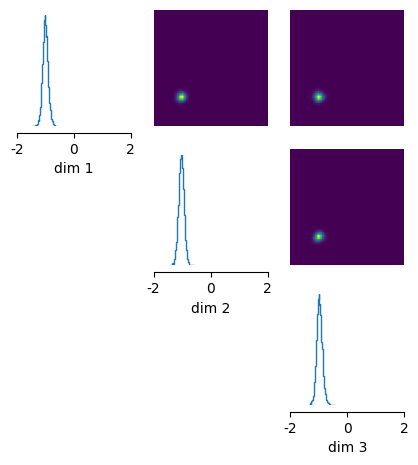

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1
posterior = infer(linear_gaussian, prior, "SNPE", num_simulations=1000)
x_o_1 = torch.zeros(3,)
x_o_2 = 2.0 * torch.ones(3,)
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

In [12]:
prior.sample()

tensor([0.3438, 0.3208, 1.5500])

## flexible interface

In [2]:
import sbi
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
# from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

In [3]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

simulator, prior = prepare_for_sbi(linear_gaussian, prior)
inference = SNPE(prior=prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 55 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

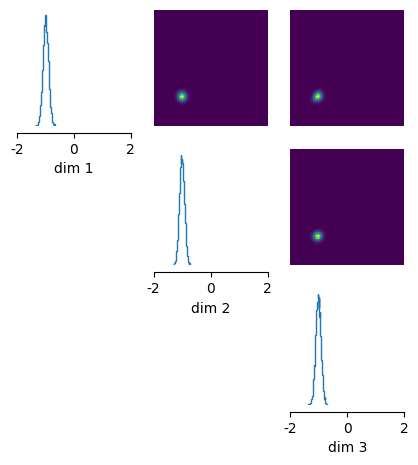

In [4]:
x_o_1 = torch.zeros(3,)
x_o_2 = 2.0 * torch.ones(3,)
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

In [29]:
# Calc Max A Posteriori parameter estimate via gradient ascent given one observation
posterior.set_default_x(x_o_1)
_map = posterior.map(num_iter=2000); _map

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[-1.0214, -1.0065, -0.9915]])

## Handling multiple (assumed iid) observations

In [2]:
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis

In [35]:
'''This doesn't work bc you need to do a more complicated embedding network thing is using NPE
   Doing so also requires more training data to be accurate according to documentation'''
# x_o_all = torch.stack([x_o_1, x_o_2])
# posterior_samples_all = posterior.sample((10000,), x=x_o_all)

# # plot posterior samples
# _ = analysis.pairplot(
#     posterior_samples_all, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
# )

In [3]:
'''Instead lets use NLE'''
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1
simulator, prior = prepare_for_sbi(linear_gaussian, prior)
inferer = SNLE(prior, show_progress_bars=True, density_estimator="mdn")
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
inferer = inferer.append_simulations(theta, x)
likelihood_estimator = inferer.train()

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 55 epochs.

In [4]:
'''Now try on multiple observations'''
# x_o = torch.zeros(3,)
# x_o = torch.stack([x_o, x_o])
x_o = torch.stack([torch.zeros(3,), torch.zeros(3,), 2.0 * torch.ones(3,)])

In [5]:
# mcmc_parameters = dict(
#     num_chains=50,
#     thin=10,
#     warmup_steps=50,
#     init_strategy="proposal",
# )
# mcmc_method = "slice_np_vectorized"

# posterior = inferer.build_posterior(
#     mcmc_method=mcmc_method,
#     mcmc_parameters=mcmc_parameters,
# )

'''Prefer this more explicit syntax'''
potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x_o
)
posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform,
    method = "slice_np_vectorized",
    num_chains=50,
    thin=10,
    warmup_steps=50,
    init_strategy="proposal",
)

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/sbiutils.py:342: UserWarning: An x with a batch size of 3 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


In [6]:
num_samples = 5000
# nle_samples = posterior.sample(sample_shape=(num_samples,), x=x_o)
nle_samples = posterior.sample(sample_shape=(num_samples,))

Running vectorized MCMC with 50 chains:   0%|          | 0/75000 [00:00<?, ?it/s]

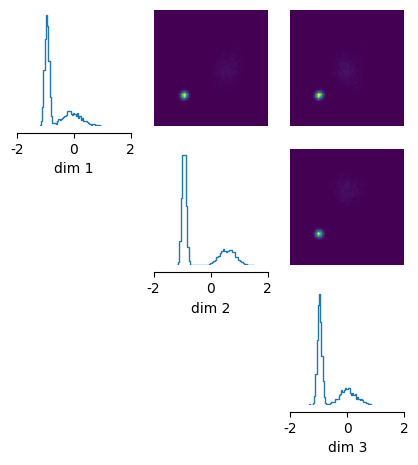

In [7]:
# plot posterior samples
_ = analysis.pairplot(
    nle_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

## Make sure it works if I write simulator in numpy

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 62 epochs.[[-2.3752413  -1.8402944   0.66075826]
 [-0.7446395   1.6399981  -0.09284437]
 [ 1.0155185   0.5165813   1.9327735 ]
 [ 1.8704715   4.1702466   1.0619937 ]
 [-0.62625945  2.0456681  -0.25942755]
 [ 3.169123   -2.7876709   1.6391056 ]
 [-1.0576285  -6.6930766   3.8927157 ]
 [-0.31481344  1.0527916   2.0495055 ]
 [ 4.360827   -1.9192369  -4.626521  ]
 [-0.29605746  0.11806017 -1.5356834 ]
 [ 1.3076115  -0.7033732   0.90311885]
 [-7.336255    1.4881345   1.40351   ]
 [ 0.13928956 -3.2057645   3.0549057 ]
 [-1.480598    1.2748239  -0.29142308]
 [-1.1629584   0.62099886 -0.928661  ]
 [-2.8937027   2.3672118   2.3840036 ]
 [-2.6247194  -0.42995173 -0.30641067]
 [ 1.8868132  -0.71977687  0.6296871 ]
 [-0.40978098 -4.1364985   6.660633  ]
 [-3.225205    1.2003578   1.9605362 ]
 [ 0.31454366 -3.0544467   0.6912242 ]
 [-2.8947368  -2.3031206   1.4395708 ]
 [ 1.1017206   2.4683826  -1.4116527 ]
 [-0.5946991   2.6091888   2.2235093 ]
 [-1.5029

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/sbiutils.py:342: UserWarning: An x with a batch size of 3 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 50 chains:   0%|          | 0/75000 [00:00<?, ?it/s]

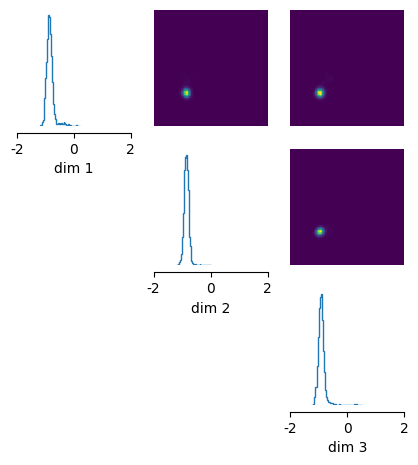

In [2]:
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def linear_gaussian(theta):
    # return theta + 1.0 + torch.randn_like(theta) * 0.1
    return theta + 1.0 + np.random.randn(np.shape(theta)[0]) * 0.1
simulator, prior = prepare_for_sbi(linear_gaussian, prior)
# all of the following work
# linear_gaussian(np.zeros(3))
# simulator(torch.tensor([0,0,0]))
# simulator(np.zeros(3))
inferer = SNLE(prior, show_progress_bars=True, density_estimator="mdn")
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
inferer = inferer.append_simulations(theta, x)
likelihood_estimator = inferer.train()
x_o = torch.stack([torch.zeros(3,), torch.zeros(3,), 2.0 * torch.ones(3,)])
potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x_o
)
posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform,
    method = "slice_np_vectorized",
    num_chains=50,
    thin=10,
    warmup_steps=50,
    init_strategy="proposal",
)
num_samples = 5000
nle_samples = posterior.sample(sample_shape=(num_samples,))
_ = analysis.pairplot(
    nle_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

In [10]:
nle_samples.shape

torch.Size([5000, 3])

In [6]:
torch.save(nle_samples, 'test.pkl')

In [7]:
torch.load('test.pkl')

tensor([[-0.9393, -0.9943, -1.0256],
        [-0.8271, -0.8672, -0.8944],
        [-0.9709, -0.9261, -0.9967],
        ...,
        [-0.6582, -0.8484, -0.9780],
        [-0.2469, -0.8311, -0.9269],
        [-0.7210, -1.0130, -0.8913]])

# My data

If posterior is hopelessly flat, can try fixing some paramters before doing inference. We could justify this well enough for an ecology journal, could argue on basis of 'expert knowledge'.

Could also introduce constraints to the likelihood maximization similar to maxent proccess to account for things estimated from the data (e.g. mortality rates at yr 14) and/or expert knowledge (e.g. Keeley not worried about senescence -> $c_m=0$, non-fire reproduction should go to basically zero after post-fire yr 2).

<!-- Here's a continuous time version, parameter labels have changed:
$\frac{\text{d}N}{\text{d}t}=N\Biggl[ \delta_{t,t_{\text{fire}}}~r_f(N,t^*)~+~\Bigr(1-\delta_{t,t_{\text{fire}}}\Bigl)~\Bigl(r(t^*) - m(N,t^*)\Bigr) \Biggr]$

$m(N,t^*)=m(t^*)\Biggl[ 1~+~\frac{\nu(t^*)}{1+\exp{(~-\gamma~(N-K(t^*)A~)}} \Biggr]$, <br /> -->

with $A$ the area inhabitated by the population (aka patch area). For model fitting, assume patch size of $1~\text{ha}$.

If we assume mortality rates are approximately constant between timesteps (not actually valid, especially for young ages, but probably fine for our purposes), the probablity of an individual of age $a-1$ growing to age $a$ is $e^{-m_{a-1}(\vec{N}(t))}$. To add demographic stochasticity, the number of survivors for a given timestep is drawn as: <br /> $\text{num survivors} \sim Bin\Bigl( e^{(-m_{a-1}(\vec{N})~\epsilon_m)},~N_{a-1}(t) \Bigr)$, <br /> with $\epsilon_m$ a lognormally distributed environmental stochasticity term.

Again assuming a constant rate per timestep, the number of seedlings (i.e. 1 yr olds) can similarly be approximated as: <br /> $\text{num offspring} \sim Poi\Bigl( r(t^*)~\epsilon_r~N(t^*) \Bigr)$.

Reasonable priors for each parameter:
- age-dependent 'baseline' mortality <br /> $m_a = \alpha_m~e^{-\beta_m~a} + \gamma_m$
    - $\alpha_m \sim \mathcal{U}(0.1, 1.8)$  (guess 0.9)
    - $\beta_m \sim \mathcal{U}(0.1, 0.8)$  (guess 0.35)
    - $\gamma_m \sim \mathcal{U}(0,0.1)$  (guess 0.03)
- environmental stochasticity in mortality <br /> $\epsilon_m \sim \text{lognorm}(0,\sigma_m~e^{-\tau_m~a})$
    - log-mean fixed at zero bc we want this centered around 1
    - $\sigma_m \sim \mathcal{U}(0, 0.6)$ (guess 0.1)
    - $\tau_m \sim \mathcal{U}(0, 0.1)$  (guess 0.02)
<!-- - age-dependent maximum mortality  -->
- age-dependent fractional change in survival <br /> $\nu_a = \alpha_{\nu}~e^{-\beta_{\nu}~a} + \gamma_{\nu}$
    - $\alpha_{\nu} \sim \mathcal{U} (0.2, 1.2)$ (guess 0.61854491)
    - $\beta_{\nu} \sim \mathcal{U} (0.05, 0.5)$ (guess 0.18939423)
    - $\gamma_{\nu} \sim \mathcal{U} (0.01, 0.12)$ (guess 0.08853605)
- age-dependent carrying capacity <br /> $K_a = K_{seedling}~e^{-\kappa~a} + K_{adult}$
    - $K_{seedling} \sim \mathcal{U} (4000, 10000)$ (guess 6000)
    - $\kappa \sim \mathcal{U} (0.15, 0.45)$ (guess 0.3)
    - $K_{adult} \sim \mathcal{U} (700, 1300)$ (guess 1024)
- density dependence 'rate' (i.e. logistic function steepness) <br /> $\eta \sim \mathcal{U} (0.01, 0.15)$ (guess 0.1)
- non-fire reproduction rate <br /> $r_{t^*} = e^{-\beta_r~t^*}$
    - $\beta_r \sim \mathcal{U} (0.75,2.5)$ (guess 1.25)
- environmental stochasticity in non-fire reproduction <br /> $\epsilon_r \sim \text{lognorm}(0,\sigma_r~e^{-\tau_r~t^*})$
    - $\sigma_r \sim \mathcal{U} (0.75, 2)$ (guess 0.5)
    - $\tau_r \sim \mathcal{U} (0.1, 2.5)$ (guess 0.4)

For the simulations, we also need to treat the initial population size as a random parameter:
- Initial population size <br /> $N_1(0) \sim \mathcal{U}(200, 14000)$

In [1]:
import torch
import numpy as np
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis
from torch.distributions import Uniform
from sbi.utils import MultipleIndependent
from torch import tensor
import pickle
import pandas as pd
import sys
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import moment

In [38]:
test = np.arange(10)

In [40]:
test[1:4] = [50,10,10]; test

array([ 0, 50, 10, 10,  4,  5,  6,  7,  8,  9])

In [41]:
test.percentile(10)

AttributeError: 'numpy.ndarray' object has no attribute 'percentile'

#### Check data and store in summary stats in observations.npy

In [47]:
res_len = 5
census_yr_vec = [2,6,8,11,14]
observations = np.empty(5*3)

fn = 'observations/density.csv'
densities_o = pd.read_csv(fn, header=None)
densities_o[0] = [round(v) for v in densities_o[0]]
census_yrs = densities_o[0].to_list()
print([census_yrs.count(v) for v in np.unique(census_yrs)])

fn = 'observations/mortality_avg.csv'
mort_o = pd.read_csv(fn, header=None)
mort_o[0] = [round(v) for v in mort_o[0]]
observations[0:res_len] = mort_o[1].to_numpy()

fn = 'observations/mortality.csv'
mort_o = pd.read_csv(fn, header=None)
mort_o[0] = [round(v) for v in mort_o[0]]
census_yrs = mort_o[0].to_list()
print([census_yrs.count(v) for v in np.unique(census_yrs)])
observations[res_len:res_len*2] = [mort_o[mort_o[0] == yr][1].to_numpy().min() for yr in census_yr_vec]
observations[res_len*2:res_len*3] = [mort_o[mort_o[0] == yr][1].to_numpy().max() for yr in census_yr_vec]

np.save('observations/observations.npy', observations)

[11, 13, 11, 8, 9, 9]
[11, 13, 13, 11, 9]


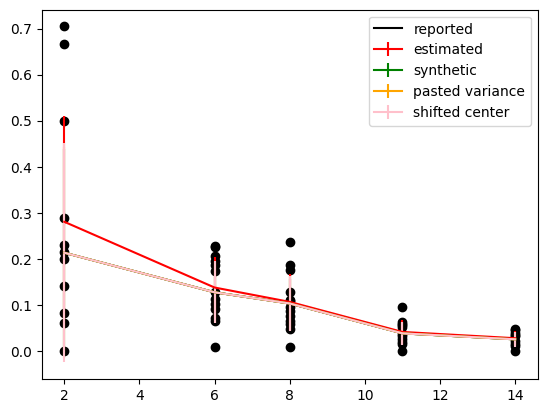

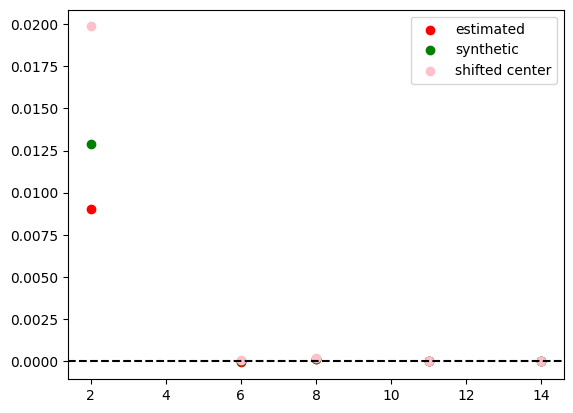

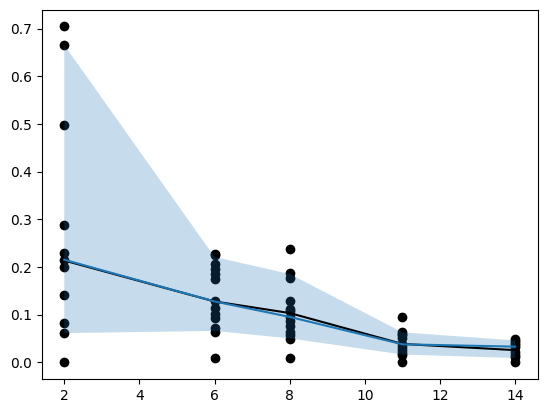

In [37]:
fn = 'observations/mortality.csv'
mortality_o = pd.read_csv(fn, header=None)
mortality_o[0] = [round(v) for v in mortality_o[0]]
plt.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')
fn = 'observations/mortality_avg.csv'
mortality_avg_o = pd.read_csv(fn, header=None)
mortality_avg_o[0] = [round(v) for v in mortality_avg_o[0]]
plt.plot(mortality_avg_o[0].to_numpy(), mortality_avg_o[1].to_numpy(), color='k', label='reported')

census_yrs = [2,6,8,11,14]
m1 = []; m2 = []; m3 = []
m1_adj = []; m2_adj = []; m3_adj = []
m2_shft = []; m3_shft = []
for t_i, t in enumerate(census_yrs):
    mort_sub = mortality_o[mortality_o[0]==t][1].to_numpy()
    est_mean = np.mean(mort_sub)
    m1.append(est_mean)
    m2.append(moment(mort_sub, moment=2))
    m3.append(moment(mort_sub, moment=3))
    # Add 'synthetic' data point to get estimated avg to match reported
    # synthetic = (len(mort_sub) + 1) * (mortality_avg_o[1][t_i]) - np.sum(mort_sub)
    # mort_sub_adj = np.append(mort_sub, [synthetic])
    num_synth = 4  #need at least 4 to make synthetic point non-negative
    synthetic = ((len(mort_sub) + num_synth) * (mortality_avg_o[1][t_i]) - np.sum(mort_sub)) / num_synth
    mort_sub_adj = np.append(mort_sub, np.repeat(synthetic, num_synth))
    # print(synthetic)
    m1_adj.append(np.mean(mort_sub_adj))
    m2_adj.append(moment(mort_sub_adj, moment=2))
    m3_adj.append(moment(mort_sub_adj, moment=3))
    # Try computing higher moments assuming reported average
    m2_shft.append(moment(mort_sub, moment=2, center=mortality_avg_o[1][t_i]))
    m3_shft.append(moment(mort_sub, moment=3, center=mortality_avg_o[1][t_i]))
plt.errorbar(census_yrs, m1, yerr=np.sqrt(m2), color='r', label='estimated')
plt.errorbar(census_yrs, m1_adj, yerr=np.sqrt(m2_adj), color='g', label='synthetic')  #std below zero
plt.errorbar(census_yrs, mortality_avg_o[1].to_numpy(), yerr=np.sqrt(m2), color='orange', label='pasted variance') #std below zero
plt.errorbar(census_yrs, mortality_avg_o[1].to_numpy(), yerr=np.sqrt(m2_shft), color='pink', label='shifted center') #std below zero
plt.legend()
plt.show()
plt.scatter(census_yrs, m3, c='r', label='estimated')
plt.scatter(census_yrs, m3_adj, c='g', label='synthetic')
plt.scatter(census_yrs, m3_shft, c='pink', label='shifted center')
plt.axhline(0, ls='--', color='k')
plt.legend()
plt.show()
plt.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')
plt.plot(mortality_avg_o[0].to_numpy(), mortality_avg_o[1].to_numpy(), color='k')
mort_subs = [mortality_o[mortality_o[0]==t][1].to_numpy() for t in census_yrs]
percentiles = np.empty((2, len(census_yrs)))
percentiles[0] = [np.percentile(ms, 10) for ms in mort_subs]
percentiles[1] = [np.percentile(ms, 90) for ms in mort_subs]
medians = [np.median(ms) for ms in mort_subs]
plt.plot(census_yrs, medians)
# plt.errorbar(census_yrs, medians, yerr=percentiles)
plt.fill_between(census_yrs, percentiles[0], percentiles[1], alpha=0.25)

In [152]:
# Save new summary stats to observations.npy
observations = np.concatenate((m1,m2,m3))
np.save('observations/observations.npy', observations)

#### Playing with parameters

In [15]:
def simulator(params):
    # Assign parameter labels
    alph_m = params[0]; beta_m = params[1]; gamm_m = params[2]
    sigm_m = params[3]; tau_m = params[4]
    alph_nu = params[5]; beta_nu = params[6]; gamm_nu = params[7]
    K_seedling = params[8]; kappa = params[9]; K_adult = params[10]
    eta = params[11]
    mu_m = params[12]

    # For generating env stochasticity multipliers
    rng = np.random.default_rng()

    # Initialize empty results array
    census_yrs = np.array([1,2,6,8,11,14])
    #results = np.empty((3, len(census_yrs)-1))
    res_len = len(census_yrs) - 1
    results = np.empty(res_len * 3)
    res_i = 0

    t_vec = np.arange(1,15)
    fn = 'observations/density.csv'
    densities_o = pd.read_csv(fn, header=None)
    densities_o[0] = [round(v) for v in densities_o[0]]
    N_0_1 = densities_o[densities_o[0] == 1][1].to_numpy()
    N_vec = np.ma.array(np.zeros((len(N_0_1), len(t_vec))))
    N_vec[:,0] = N_0_1
    N_vec = N_vec.astype(int)
    census_init = N_vec.sum(axis=1)
    census_yr_init = t_vec[0]

    m_a = alph_m * np.exp(-beta_m*t_vec) + gamm_m
    K_a = K_seedling * np.exp(-kappa*t_vec) + K_adult
    nu_a = alph_nu * np.exp(-beta_nu*t_vec) + gamm_nu

    for age_i, t in enumerate(t_vec[:-1]):
        for pop_i, N_pop in enumerate(N_vec):
            # If pop already extirpated, skip
            if (np.ma.is_masked(N_vec)) and (np.ma.getmask(N_vec)[pop_i, 0]):
                continue
            # Add density dependent term to mortalities
            dens_dep = ((nu_a)*(1-m_a)) / (1 + np.exp(-eta*K_adult*(np.sum(N_pop/K_a) - 1)))
            m_a_N = m_a + dens_dep
            # Draw env. stoch. terms and combine for final survival prob.
            epsilon_m = rng.lognormal(np.zeros_like(t_vec)+mu_m, sigm_m*np.exp(-tau_m*t_vec))
            survival_probs = np.exp(-m_a_N * epsilon_m)
            num_survivors = rng.binomial(N_pop, survival_probs)
            num_survivors = np.roll(num_survivors, 1)
            # Finally, update abundances
            N_vec[pop_i] = num_survivors
            # Note if population was extirpated
            if np.sum(num_survivors) == 0:
                #print('pop {} extirpated'.format(pop_i))
                N_vec[pop_i, :] = np.ma.masked
                census_init[pop_i] = np.ma.masked
                #print(N_vec)
        # If enough populations extirpated, consider parameter set invalid
        if (np.ma.is_masked(N_vec)) and (sum(np.ma.getmask(N_vec)[:,0]) > 3):
            #print('invalid sim')
            results[0:res_len] = np.ones(len(census_yrs)-1)*10
            results[res_len:res_len*2] = np.ones(len(census_yrs)-1)*-1
            results[res_len*2:res_len*3] = np.ones(len(census_yrs)-1)*20
            break
        elif t+1 in census_yrs:
            # Calculate and store mortality stats
            delta_t = (t+1) - census_yr_init
            census_final = N_vec.sum(axis=1)
            mortality = ((census_init - census_final) / census_init) / delta_t
            results[res_i] = np.mean(mortality)
            results[res_len + res_i] = np.min(mortality)
            results[res_len*2 + res_i] = np.max(mortality)
            # Reset for next census
            res_i += 1
            census_init = census_final
            census_yr_init = t+1
    return results

In [2]:
def simulator(params):
    # Assign parameter labels
    alph_m = params[0]; beta_m = params[1]; gamm_m = params[2]
    sigm_m = params[3]; tau_m = params[4]
    alph_nu = params[5]; beta_nu = params[6]; gamm_nu = params[7]
    K_seedling = params[8]; kappa = params[9]; K_adult = params[10]
    eta = params[11]
    mu_m = params[12]

    # For generating env stochasticity multipliers
    rng = np.random.default_rng()

    # Initialize empty results array
    census_yrs = np.array([1,2,6,8,11,14])
    #results = np.empty((3, len(census_yrs)-1))
    res_len = len(census_yrs) - 1
    results = np.empty(res_len * 3)
    res_i = 0

    t_vec = np.arange(1,15)
    fn = 'observations/density.csv'
    densities_o = pd.read_csv(fn, header=None)
    densities_o[0] = [round(v) for v in densities_o[0]]
    N_0_1 = densities_o[densities_o[0] == 1][1].to_numpy()
    N_vec = np.ma.array(np.zeros((len(N_0_1), len(t_vec))))
    N_vec[:,0] = N_0_1
    N_vec = N_vec.astype(int)
    census_init = N_vec.sum(axis=1)
    census_yr_init = t_vec[0]

    m_a = alph_m * np.exp(-beta_m*t_vec) + gamm_m
    K_a = K_seedling * np.exp(-kappa*t_vec) + K_adult
    nu_a = alph_nu * np.exp(-beta_nu*t_vec) + gamm_nu

    for age_i, t in enumerate(t_vec[:-1]):
        for pop_i, N_pop in enumerate(N_vec):
            # If pop already extirpated, skip
            if (np.ma.is_masked(N_vec)) and (np.ma.getmask(N_vec)[pop_i, 0]):
                continue
            # Add density dependent term to mortalities
            dens_dep = ((nu_a)*(1-m_a)) / (1 + np.exp(-eta*K_adult*(np.sum(N_pop/K_a) - 1)))
            m_a_N = m_a + dens_dep
            # Draw env. stoch. terms and combine for final survival prob.
            epsilon_m = rng.lognormal(np.zeros_like(t_vec)+mu_m, sigm_m*np.exp(-tau_m*t_vec))
            survival_probs = np.exp(-m_a_N * epsilon_m)
            num_survivors = rng.binomial(N_pop, survival_probs)
            num_survivors = np.roll(num_survivors, 1)
            # Finally, update abundances
            N_vec[pop_i] = num_survivors
            # Note if population was extirpated
            if np.sum(num_survivors) == 0:
                #print('pop {} extirpated'.format(pop_i))
                N_vec[pop_i, :] = np.ma.masked
                census_init[pop_i] = np.ma.masked
                #print(N_vec)
        # If enough populations extirpated, consider parameter set invalid
        if (np.ma.is_masked(N_vec)) and (sum(np.ma.getmask(N_vec)[:,0]) > 3):
            #print('invalid sim')
            results[0:res_len] = np.ones(len(census_yrs)-1)*10
            results[res_len:res_len*2] = np.ones(len(census_yrs)-1)*20
            results[res_len*2:res_len*3] = np.ones(len(census_yrs)-1)*20
            break
        elif t+1 in census_yrs:
            # Calculate and store mortality stats
            delta_t = (t+1) - census_yr_init
            census_final = N_vec.sum(axis=1)
            mortality = ((census_init - census_final) / census_init) / delta_t
            results[res_i] = np.mean(mortality)
            results[res_len + res_i] = moment(mortality, moment=2)
            results[res_len*2 + res_i] = moment(mortality, moment=3)
            # Reset for next census
            res_i += 1
            census_init = census_final
            census_yr_init = t+1
    return results

In [59]:
def plt_sim(alph_m = 0.9, beta_m = 0.35, gamm_m = 0.03,
            sigm_m = 0.1, tau_m = 0.02,
            alph_nu = 0.6185, beta_nu = 0.189, gamm_nu = 0.088,
            K_seedling = 6000*10, kappa = 0.3, K_adult = 1024*10, eta = 0.1, mu_m = 0.0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    census_yrs = [2,6,8,11,14]
    fn = 'observations/mortality.csv'
    mortality_o = pd.read_csv(fn, header=None)
    mortality_o[0] = [round(v) for v in mortality_o[0]]
    # plt.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')
    # fn = 'observations/mortality_avg.csv'
    # mortality_avg_o = pd.read_csv(fn, header=None)
    # mortality_avg_o[0] = [round(v) for v in mortality_avg_o[0]]
    # plt.plot(mortality_avg_o[0].to_numpy(), mortality_avg_o[1].to_numpy(), color='k')
    m1 = []; m2 = []; m3 = []
    for t_i, t in enumerate(census_yrs):
        mort_sub = mortality_o[mortality_o[0]==t][1].to_numpy()
        est_mean = np.mean(mort_sub)
        m1.append(est_mean)
        m2.append(moment(mort_sub, moment=2))
        m3.append(moment(mort_sub, moment=3))
    ax1.errorbar(census_yrs, m1, yerr=np.sqrt(m2), color='k', fmt='o')
    
    params = [alph_m, beta_m, gamm_m, sigm_m, tau_m, alph_nu, 
              beta_nu, gamm_nu, K_seedling, kappa, K_adult, eta, mu_m]
    reps = 100
    num_invalid = 0
    all_res = np.zeros((reps,3*5))
    for rep in range(reps):
        res = simulator(params)
        if np.all(res[0:5] == 10):
            num_invalid += 1
            continue
        all_res[rep] = res
    all_res = np.delete(all_res, -num_invalid, axis=0)
    res = np.mean(all_res, axis=0)
    print('{} sims with >3 extirpations'.format(num_invalid))
    plt.axhline(0, ls='--', color='k')
    # plt.plot(census_yrs, res[0:5])
    # plt.fill_between(census_yrs, res[5:10], res[10:15], alpha=0.25)
    # ax1.errorbar(census_yrs, res[0:5], yerr=np.sqrt(res[5:10]), fmt='o', alpha=0.75, c='magenta')
    ax1.scatter(census_yrs, res[0:5], c='magenta', alpha=0.75)
    ax1.fill_between(census_yrs, res[0:5]-np.sqrt(res[5:10]), res[0:5]+np.sqrt(res[5:10]), color='magenta', alpha=0.2)
    ax1.set_ylim(-0.1,0.8)
    
    ax2.scatter(census_yrs, m3, c='k')
    ax2.scatter(census_yrs, res[10:15], alpha=0.75, c='magenta')
    
defaults = np.array([0.9,0.35,0.03,0.1,0.02,0.6185,0.189,0.088,6000*10,0.3,1024*10,0.1,0.0])
interact(plt_sim,
         alph_m = widgets.FloatSlider(value=0.25, min=0.01, max=defaults[0]*1.75, step=defaults[0]/40, continuous_update=False),#
         beta_m = widgets.FloatSlider(value=0.26, min=defaults[1]*0.25, max=defaults[1]*1.75, step=defaults[1]/40, continuous_update=False),
         gamm_m = widgets.FloatSlider(value=0.01, min=defaults[2]*0.25, max=defaults[2]*1.75, step=defaults[2]/40, continuous_update=False),
         sigm_m = widgets.FloatSlider(value=1., min=0., max=1.7, step=defaults[3]/40, continuous_update=False),#
         tau_m = widgets.FloatSlider(value=0.01, min=0.0, max=0.4, step=defaults[4]/40, continuous_update=False),
         alph_nu = widgets.FloatSlider(value=0.45, min=0.01, max=3, step=defaults[5]/40, continuous_update=False),#
         beta_nu = widgets.FloatSlider(value=0.1, min=defaults[6]*0.25, max=defaults[6]*1.75, step=defaults[6]/40, continuous_update=False),
         gamm_nu = widgets.FloatSlider(value=0.1, min=defaults[7]*0.25, max=defaults[7]*1.75, step=defaults[7]/40, continuous_update=False),
         K_seedling = widgets.FloatSlider(value=60000, min=defaults[8]*0.001, max=defaults[8]*5, step=10, continuous_update=False),
         kappa = widgets.FloatSlider(value=0.4, min=0.01, max=0.9, step=defaults[9]/40, continuous_update=False),
         K_adult = widgets.FloatSlider(value=defaults[10], min=defaults[10]*0.25, max=defaults[10]*1.75, step=defaults[10]/40, continuous_update=False),
         eta = widgets.FloatSlider(value=0.02, min=0.01, max=0.6, step=defaults[11]/40, continuous_update=False),
         mu_m = widgets.FloatSlider(value=0.0, min=-0.2, max=0.1, step=0.01, continuous_update=False))
defaults = np.array([0.2, 0.8, 0.45])
# n = 200
# widths = [(v*1.9-v*0.1)/(2*n) for v in defaults]; print(widths)
ranges = np.array([[0.01, 0.6], [0.1,0.9], [0.05,0.95]])
fixed = {'beta_m': 0.26, 'gamm_m': 0.01, 'tau_m': 0.01, 'beta_nu': 0.1, 'gamm_nu': 0.1, 
         'K_seedling': 60000, 'kappa': 0.4, 'K_adult': 10000, 'eta': 0.02, 'mu_m': 0.0}

interactive(children=(FloatSlider(value=0.25, continuous_update=False, description='alph_m', max=1.575, min=0.…

#### sbi

In [2]:
priors = [
    # m_a
    Uniform(tensor([0.1]), tensor([1.8])), 
    Uniform(tensor([0.1]), tensor([0.8])),
    Uniform(tensor([0.]), tensor([0.1])),
    # epsilon_m
    Uniform(tensor([0.]), tensor([0.6])),
    Uniform(tensor([0.]), tensor([0.1])),
    # nu_a
    Uniform(tensor([0.2]), tensor([1.2])),
    Uniform(tensor([0.05]), tensor([0.5])),
    Uniform(tensor([0.01]), tensor([0.12])),
    # K_a
    Uniform(tensor([4000.]), tensor([10000.])),
    Uniform(tensor([0.15]), tensor([0.45])),
    Uniform(tensor([700.]), tensor([1300.])),
    # eta
    Uniform(tensor([0.01]), tensor([0.15])),
    # r_a
    Uniform(tensor([0.75]), tensor([2.5])),
    # epsilon_r
    Uniform(tensor([0.75]), tensor([2.])),
    Uniform(tensor([0.1]), tensor([2.5]))#,
    # N_1(0)
    #Uniform(tensor([200.]), tensor([16000.]))
]
prior = MultipleIndependent(priors)
# params = prior.sample().numpy(); params

In [77]:
n = 200
test = [(p.high.numpy()[0] - p.low.numpy()[0]) / (2*n) for p in priors]; print(test)

[0.004249999821186065, 0.0017499999701976775, 0.0002500000037252903, 0.0015000000596046448, 0.0002500000037252903, 0.0025, 0.0011249999701976776, 0.0002749999985098839, 15.0, 0.0007499999552965164, 1.5, 0.00035000000149011613, 0.004375, 0.003125, 0.006000000238418579]


In [141]:
prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)
simulator = utils.user_input_checks.process_simulator(simulator, prior, is_numpy_simulator=True)

In [142]:
inferer = SNLE(prior, show_progress_bars=True, density_estimator="mdn")
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=200000)
inferer = inferer.append_simulations(theta, x)
likelihood_estimator = inferer.train()

Running 200000 simulations.:   0%|          | 0/200000 [00:00<?, ?it/s]

 Neural network successfully converged after 45 epochs.

In [143]:
# Write likelihood estimator to file
with open("likelihood_estimator.pkl", "wb") as handle:
    pickle.dump(likelihood_estimator, handle)

In [6]:
# Read likelihood estimator from file
with open("likelihood_estimator.pkl", "rb") as handle:
    likelihood_estimator = pickle.load(handle)

In [7]:
x_o = np.load('observations.npy')
x_o = torch.Tensor(x_o)
potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x_o
)

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/sbiutils.py:342: UserWarning: An x with a batch size of 11 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


In [8]:
posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform,
    method = "slice_np_vectorized",
    num_chains=1,
    thin=10,
    warmup_steps=50,
    init_strategy="proposal",
)
num_samples = 50000
nle_samples = posterior.sample(sample_shape=(num_samples,))

Running vectorized MCMC with 1 chains:   0%|          | 0/500500 [00:00<?, ?it/s]

tensor([-1.3426e+37])
BEGIN
tensor([-1.3426e+37])
LOWER
tensor([-1.3426e+37])
UPPER
HERE
tensor([-1.3426e+37])
UPPER
HERE
tensor([-1.3426e+37])
UPPER
HERE
tensor([-1.3426e+37])
UPPER
HERE
tensor([-1.3425e+37])
UPPER
HERE
tensor([-1.3425e+37])
UPPER
HERE
tensor([-1.3425e+37])
UPPER
HERE
tensor([-1.3425e+37])
UPPER
HERE
tensor([-1.3425e+37])
UPPER
HERE
tensor([-1.3425e+37])
UPPER
HERE
tensor([-1.3425e+37])
UPPER
HERE
tensor([-1.3424e+37])
UPPER
HERE
tensor([-1.3424e+37])
UPPER
HERE
tensor([-1.3424e+37])
UPPER
HERE
tensor([-1.3424e+37])
UPPER
HERE
tensor([-1.3424e+37])
UPPER
HERE
tensor([-1.3424e+37])
UPPER
HERE
tensor([-1.3424e+37])
UPPER
HERE
tensor([-1.3423e+37])
UPPER
HERE
tensor([-1.3423e+37])
UPPER
HERE
tensor([-1.3423e+37])
UPPER
HERE
tensor([-1.3423e+37])
UPPER
HERE
tensor([-1.3423e+37])
UPPER
HERE
tensor([-1.3423e+37])
UPPER
HERE
tensor([-1.3423e+37])
UPPER
HERE
tensor([-1.3423e+37])
UPPER
HERE
tensor([-1.3422e+37])
UPPER
HERE
tensor([-1.3422e+37])
UPPER
HERE
tensor([-1.3422e+37]


KeyboardInterrupt



In [5]:
limits = [[p.low.numpy()[0], p.high.numpy()[0]] for p in priors]

In [41]:
labels = ['alph_m','beta_m','gamm_m','sigm_m','tau_m','alph_nu','beta_nu','gamm_nu','K_seedling','kappa',
          'K_adult','eta','beta_r','sigm_r', 'tau_r']

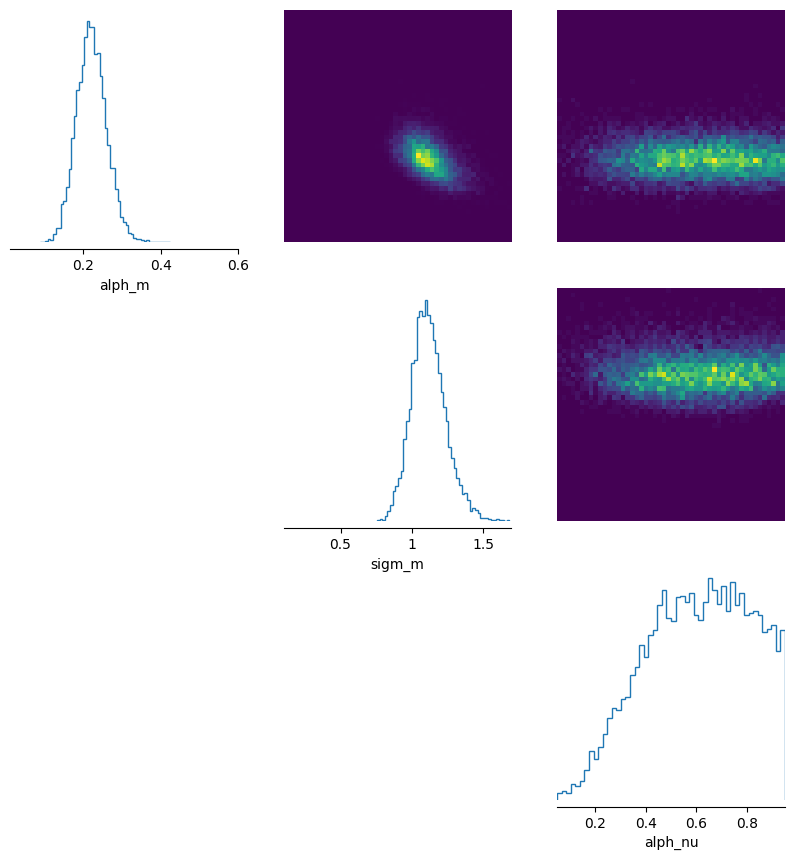

In [56]:
limits = [[0.01, 0.6], [0.1,1.7], [0.05,0.95]]
labels = ['alph_m','sigm_m','alph_nu']
nle_samples = torch.load('posterior_samples.pkl')
_ = analysis.pairplot(
    nle_samples, limits=limits, figsize=(10, 10), labels=labels
)

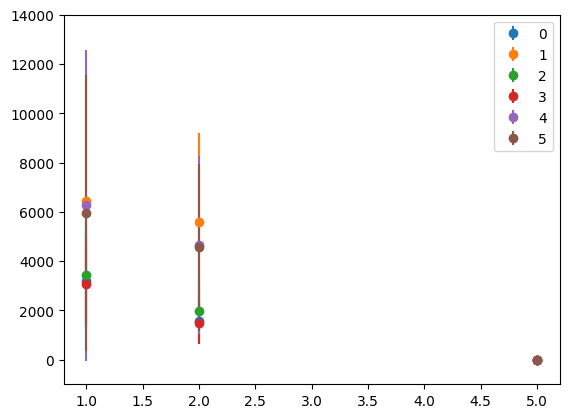

In [ ]:
slc = [-5,-1]
filt = [0,100,200,450,475,499]
tstar = np.array([1,2,5])
# for i, params in enumerate(nle_samples[slc[0]:slc[1]]):
for i, params in enumerate(nle_samples[filt]):
    params = params.numpy()
    num_sims = 1000
    D_vec = np.zeros((num_sims, 3))
    for sim_i in range(num_sims):
        D_vec[sim_i] = simulator(params)
    mean_vec = D_vec.mean(axis=0)
    std_vec = D_vec.std(axis=0)
    plt.errorbar(tstar, mean_vec, yerr=std_vec, fmt='o', label=i)
plt.ylim(-1000,14000)
plt.legend()

In [ ]:
mean_vec

array([6.122232e+003, 4.633491e+003, 2.470328e-323])

In [ ]:
std_vec

array([5853.13488912, 3411.88970336,    0.        ])